In [1]:
import numpy
import matplotlib
import glob
from matplotlib import pyplot as plt

import tpx

In [2]:
output = {}
for camera in ["Counting", "ToT", "ToT_ToA"]:
    output[camera] = {}
    for tpc in ["", "-everythingOFF"]:
        match_string = f"/home/cadams/CRAB/Avalanche//{camera}{tpc}/frame*.tpx3"
        files = glob.glob(match_string)
        data = numpy.concatenate([tpx.parse_binary_file(f) for f in files])

        output[camera][tpc] = data
# tpc_files = {}

# tpc_on_counting  = [ tpx.parse_binary_file(f) for f in tpc_on_counting_files ]
# tpc_off_counting = [ tpx.parse_binary_file(f) for f in tpc_off_counting_files ]
# tpc_on_tot       = [ tpx.parse_binary_file(f) for f in tpc_on_tot_files ]

In [3]:
def analyze_hits(tpx_arr, time_gap_threshold = 1e5):
    times = tpx_arr["TOA"]
    gaps = times[1:] - times[:-1]
    slices_edges = numpy.where(gaps > time_gap_threshold)[0]
    # print(slices_edges)
    # print(slices)
    hit_ToT = []
    hit_x   = []
    hit_y   = []
    hit_t   = []
    start = 0
    for i_end in slices_edges:
        # print(start, i_end)
        this_hit = tpx_arr[start:i_end+1]
        total_charge = numpy.sum(this_hit["TOT"])
        hit_ToT.append(total_charge)
        hit_x.append(numpy.sum(this_hit["TOT"]*this_hit["x"]) / total_charge)
        hit_y.append(numpy.sum(this_hit["TOT"]*this_hit["y"]) / total_charge)
        hit_t.append(numpy.max(this_hit["TOA"]))
        start = i_end+1
    return {"tot": hit_ToT, "x": hit_x, "y":hit_y, "toa": hit_t}

In [4]:
analyzed_hits = {}
for camera in ["Counting", "ToT", "ToT_ToA"]:
    analyzed_hits[camera] = {}
    for tpc in ["", "-everythingOFF"]:
        print(camera, tpc, output[camera][tpc].shape)
        analyzed_hits[camera][tpc] = analyze_hits(output[camera][tpc])

Counting  (1114,)
Counting -everythingOFF (11893,)
ToT  (1244,)
ToT -everythingOFF (7966,)
ToT_ToA  (654,)
ToT_ToA -everythingOFF (10736,)


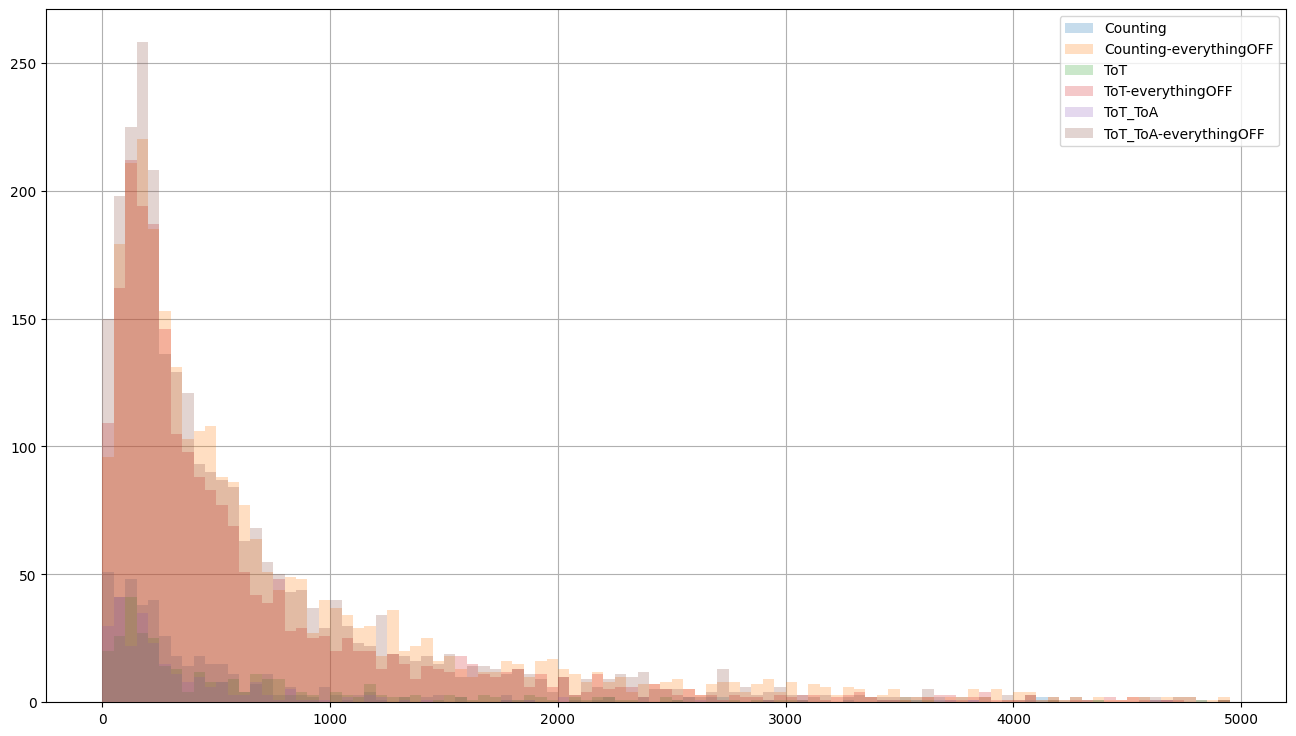

In [5]:
bin_width=50
bins = numpy.arange(0,5000,bin_width)

figure = plt.figure(figsize=(16,9))

for camera in ["Counting", "ToT", "ToT_ToA"]:
    for tpc in ["", "-everythingOFF"]:

        on, edges  = numpy.histogram(analyzed_hits[camera][tpc]["tot"], bins=bins)

        # Normalization:
        # on = on / total_times["el-.88kV_II-2V_counting_000000"]
        # off = off / total_times["el-.5kV_II-2V_counting_000001"]
        # el0 = el0 / total_times["el-off_II-on_counting_evacuated_000000"]

        # print(on)

        bin_centers = 0.5*(edges[1:] + edges[:-1])

        plt.bar(bin_centers, on, width = bin_width, label=f"{camera}{tpc}", zorder=3, alpha=0.25)


plt.grid(True)
plt.legend()

In [6]:
print(output.keys())

dict_keys(['Counting', 'ToT', 'ToT_ToA'])


In [7]:
output["Counting"][""].dtype

dtype([('TOA', '<f8'), ('TOT', '<f8'), ('x', '<i4'), ('y', '<i4')])

In [8]:
plot_output = output
key1 = "Counting"
key2 = "-everythingOFF"
x = output[key1][key2]["y"]
y = output[key1][key2]["x"]
z = output[key1][key2]["TOA"] / 1e9
print(z)

[ 1.15149259  1.19005062  1.19005058 ... 13.92700333 13.92700339
 13.9755637 ]


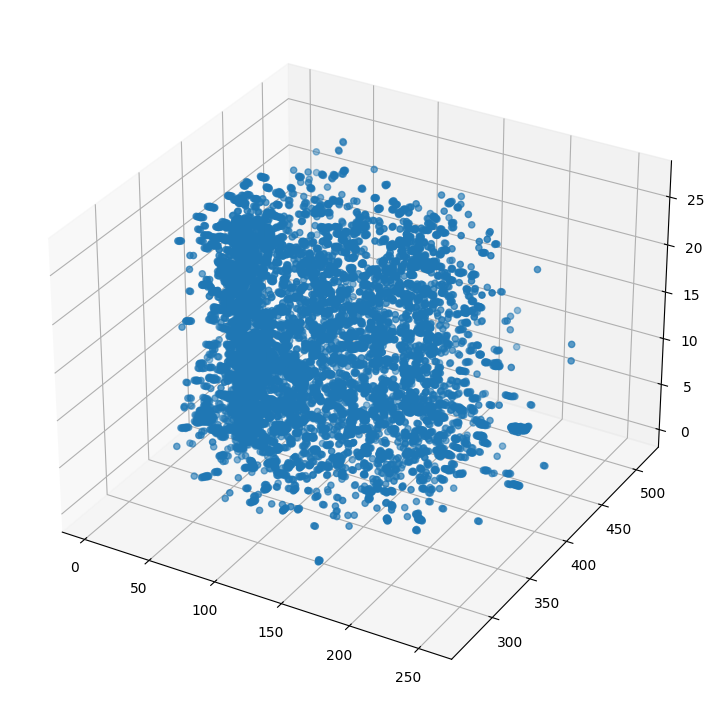

In [9]:


ax = plt.figure(figsize=(20,9)).add_subplot(projection='3d')
ax.scatter(x, y, zs=z, zdir='z', label='points in (x, z)')

(0, 0)
0.0


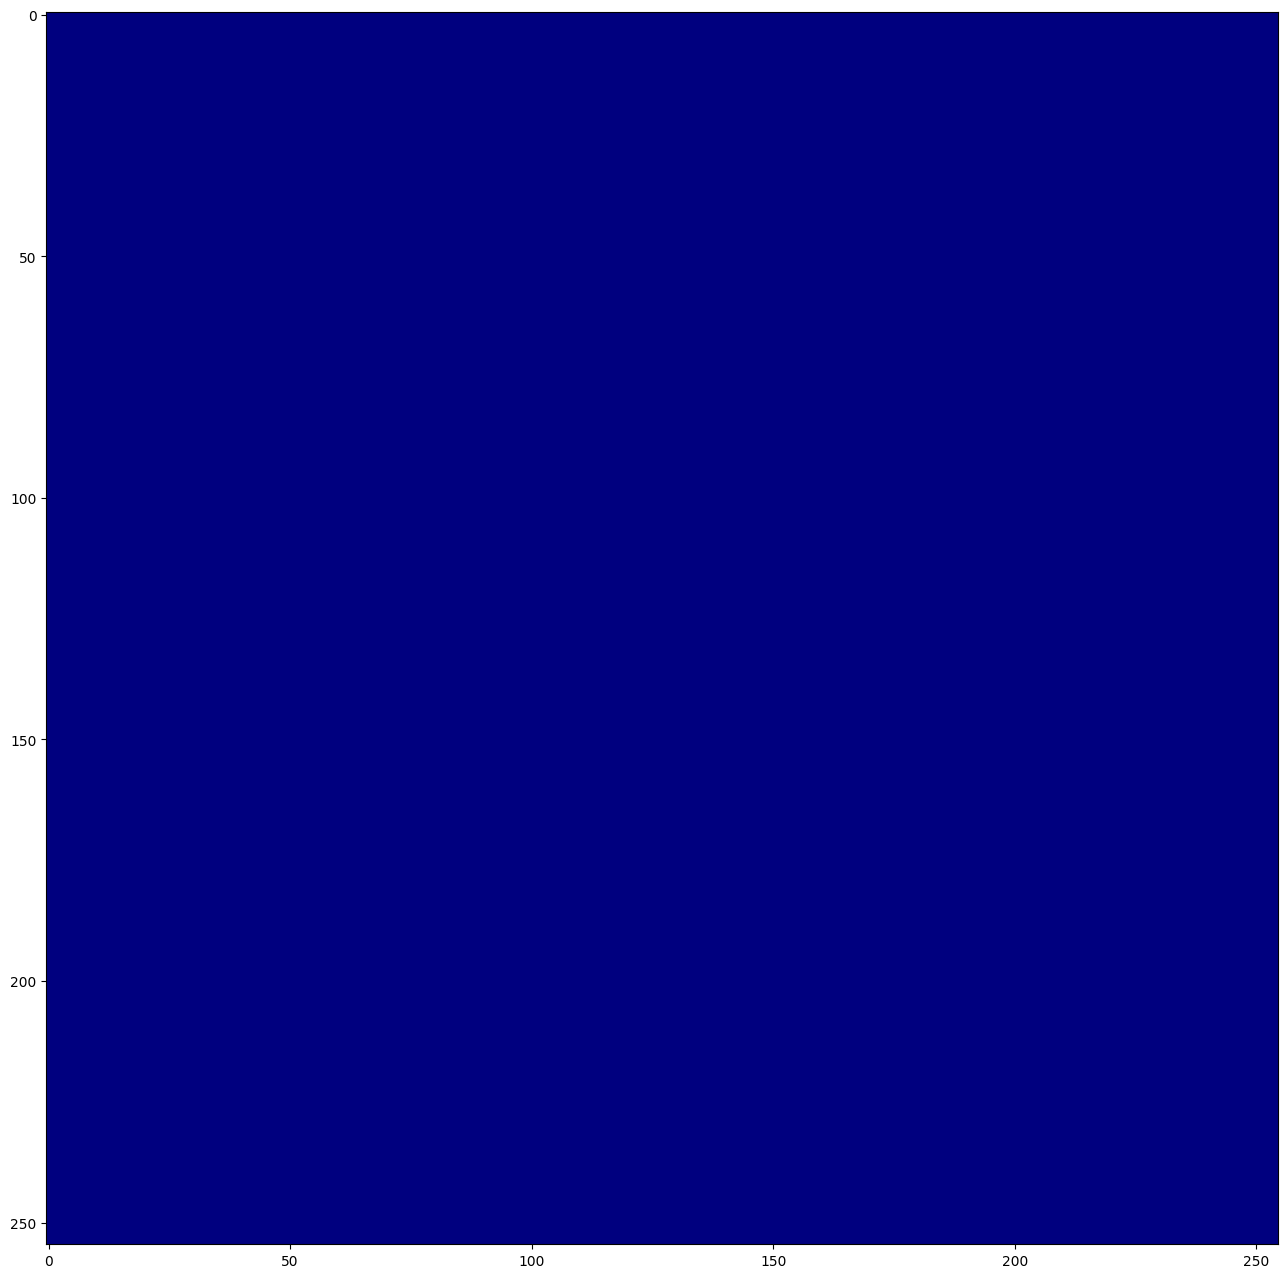

In [10]:

bins = numpy.arange(0,256)
image, x_edges, y_edges = numpy.histogram2d(x-256,y, bins=bins)


# mask the bright pixel:
pixel_index = numpy.argmax(image)

print(numpy.unravel_index(pixel_index, image.shape))

image[numpy.unravel_index(pixel_index, image.shape)] = 0.0

print(numpy.max(image))

fig = plt.figure(figsize=(16,16))

plt.imshow(image, cmap='jet', vmin=0, vmax=15)

(255, 255)
(150, 149)
5025.0


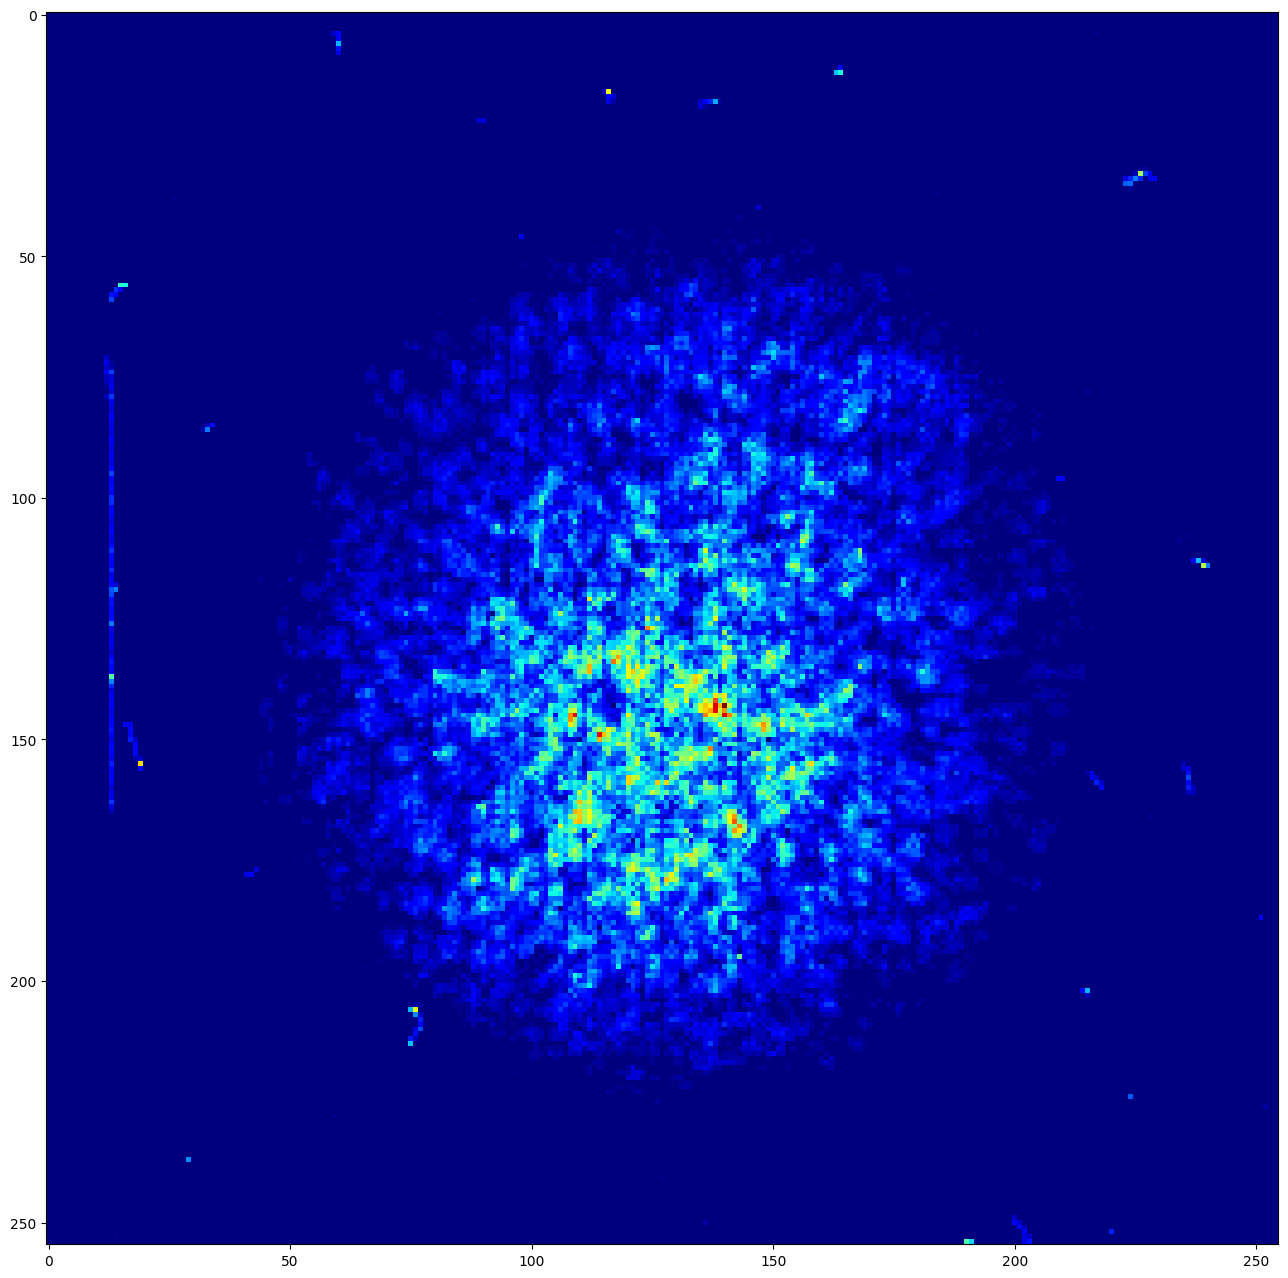

In [11]:
lamp_data = tpx.parse_binary_file("camera-4-17-23/frames_000010.tpx3")
x = lamp_data['x']
y = lamp_data['y']
z = lamp_data['TOT']

bins = numpy.arange(0,256)
image, x_edges, y_edges = numpy.histogram2d(x-256,y,weights=z, bins=bins)
print(image.shape)

# mask the bright pixel:
pixel_index = numpy.argmax(image)

print(numpy.unravel_index(pixel_index, image.shape))

image[numpy.unravel_index(pixel_index, image.shape)] = 0.0

print(numpy.max(image))

fig = plt.figure(figsize=(16,16))

plt.imshow(image, cmap='jet')

In [12]:
f = tpx.frame(fname="/home/cadams/CRAB/analysis/WithXenon_11-1-23/frames_TPC-on_0V-ELAV_000007.tpx3")

In [13]:
h = tpx.hits(input_frame=f, minimum_time_separation=1e-7)

In [14]:
h = h.threshold(150)
h = h.threshold_n(1)
print(h.shape)

(21987,)


In [15]:
import vispy.plot as vp

time_data = h['TOA']/1e9
print(time_data)

# Plot the data over time
min_time = time_data.min()
max_time = time_data.max()

bins = numpy.linspace(min_time, max_time, 50000)
bin_centers = 0.5*(bins[1:] + bins[:-1])
bin_widths  = bins[1:] - bins[:-1]

values, bin_edges = numpy.histogram(time_data, bins=bins)
# print(values)
hit_times = numpy.stack([bin_centers, values], axis=-1)

print(hit_times[hit_times[:,1] > 100])

# fig = vp.Fig(show=False)

# line.set_gl_state(depth_test=False)
# fig[0, 0].plot(values, bins=bin_centers, color='b', orientation='h')
# fig[0:4, 4].histogram(data[:, 1], bins=n_bins, color=color, orientation='v')

# fig.show(run=True)

[0.06976508 0.06976507 0.06976507 ... 0.05808372 0.05808372 0.05808372]
[[   8.71723613  202.        ]
 [  14.55063937 2306.        ]
 [  14.55117592 2671.        ]
 [  14.55224903 3396.        ]
 [  14.55278558 2418.        ]
 [  14.55332213 3228.        ]
 [  14.61931814 2295.        ]
 [  26.25446799  223.        ]]


In [63]:
print(f['TOA'])
# selected = f.time_slice(14.5e9, 14.6e9)
selected = f.time_slice(8.7e9, 15e9)

print(selected.shape)

x = selected.data['x']
y = selected.data['y']
z = selected.data['TOA']/1e8
size = selected.data['TOT']/500

[59952707.8125 69765092.1875 69765125.     ... 58083717.1875 58083715.625
 58083734.375 ]
(58303,)


In [64]:
import vispy
%gui qt

In [65]:
from vispy.scene import visuals

In [66]:
plot_data = numpy.stack([x,y,z], axis=-1)
plot_data.shape

(58303, 3)

In [67]:
canvas = vispy.scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()

scatter = visuals.Markers()
scatter.set_data(plot_data, edge_width=0, face_color=(1, 1, 1, .5), 
                #  size=size, 
                 symbol='o')

view.add(scatter)


view.camera = 'turntable'  # or try 'arcball'

# add a colored 3D axis for orientation
axis = visuals.XYZAxis(parent=view.scene)